Consider the following equation
$$- u''  = f, \quad x\in \Omega$$
$$u = 0, \quad x \in \partial \Omega.$$
We choose the true solution $u = x(e^{-(x-\frac{1}{3})^2/K} - e^{-\frac{4}{9}/K})$ with $K = 0.01$ on the interval $\Omega = [-1,1]$.

By FOSLS method, we have 
$$\sigma = - u'.$$
And the loss function
$$G(\sigma, u; f) = \|\text{div }\sigma + u -f \|_{0,\Omega}^2 + \|\frac{1}{\varepsilon}\sigma + \varepsilon \nabla u\|_{0,\Omega}^2 + \beta \|u\|^2_{0,\Omega}$$

In [6]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim
from math import exp

In [8]:
# initialize parameters
global k, dx, beta 
k, dx, beta = .01, .002, 500

In [9]:
def f(x):
    return -(2*exp(-(x - 1/3)**2/k)*(6*k + 2*x - 27*k*x - 12*x**2 + 18*x**3))/(9*k**2)
  
def g(x):
    return torch.tensor([0.], requires_grad=True)

def u_exact(x):
    return x*(exp(-1/k*(x-1/3)**2) - exp(-4/(9*k)))

def sigma_exact(x):
    return exp(-4/(9*k)) - exp(-(x - 1/3)**2/k) + (x*exp(-(x - 1/3)**2/k)*(2*x - 2/3))/k
  
sq = lambda x: x ** 2
vsq = np.vectorize(sq)

In [10]:
# compute H1 norm of true u and sigma
L = 0.
R = 1.
test_set =  np.arange(L, R+dx, dx)
u = np.vectorize(u_exact)(test_set)
ud = -np.vectorize(sigma_exact)(test_set)
u_h1 = np.sum(dx*(vsq(u) + vsq(ud)))
u_l2 = np.sum(dx*vsq(u))

sigma = np.vectorize(sigma_exact)(test_set)
sigmad = np.vectorize(f)(test_set)
sigma_h1 = np.sum(dx*(vsq(sigma) + vsq(sigmad)))
sigma_l2 = np.sum(dx*vsq(sigma))

print('u: H1 norm square: %.6f, L2 norm square: %.6f ' %(u_h1, u_l2))
print('sigma: H1 norm square: %.6f, L2 norm square: %.6f ' %(sigma_h1, sigma_l2))

u: H1 norm square: 1.500809, L2 norm square: 0.014239 
sigma: H1 norm square: 466.257229, L2 norm square: 1.486570 


In [11]:
class MuSigmaPde(nn.Module):
    def __init__(self, dimension, mesh = 24, neuron = 14):
        super(MuSigmaPde, self).__init__()

        self.xdim = dimension
        # Layer 1
        self.fc1mu = nn.Linear(dimension, mesh)
        self.fc1sig = nn.Linear(dimension, mesh)
        # Layer 2
        self.fc2mu = nn.Linear(mesh, neuron)
        self.fc2sig = nn.Linear(mesh, neuron)
        # Layer 3
        self.fc3mu = nn.Linear(neuron, neuron)
        self.fc3sig = nn.Linear(neuron, neuron)
        # Layer 4
        self.fc4mu = nn.Linear(neuron, 1)
        self.fc4sig = nn.Linear(neuron, dimension)

    def forward(self, x):
        assert(len(x.shape) == 1 and x.shape[0] == self.xdim)
        mu =  F.leaky_relu(self.fc2mu(F.leaky_relu(self.fc1mu(x))))
        sig =  F.leaky_relu(self.fc2sig(F.leaky_relu(self.fc1sig(x))))
        mu =  self.fc4mu(F.leaky_relu(self.fc3mu(mu)) + mu)
        sig = self.fc4sig(F.leaky_relu(self.fc3sig(sig)) + sig)
        return mu, sig
      
    def net_grad(self, x):
        mu_center, sigma_center = self.forward(x)
        mu_forward, sigma_forward = self.forward(x - dx)
#         mu_backward, sigma_backward = self.forward(x + h)

        mu_grad_forward = (mu_center - mu_forward)/(dx)
        sigma_grad_forward = (sigma_center - sigma_forward)/(dx)
    
        return mu_grad_forward, sigma_grad_forward
    
    def loss_function_bulk(self, x):
        mu, sigma = self.forward(x)
        mu_grad, sigma_grad = self.net_grad(x)
        LSE = torch.sum((mu_grad + sigma)**2) + (sigma_grad - f(x))**2
        return LSE 

    def loss_function_surf(self, x):
        mu, sigma = self.forward(x)
        # Boundary condition penalty
        BCP = beta * (mu - g(x))**2
        return BCP

In [13]:
model = MuSigmaPde(dimension =1, mesh = 24, neuron = 14)

In [14]:
sum([p.numel() for p in model.parameters()])

1246

In [27]:
h = .005
epochs = 1000
L, R = 0., 1.
bulk_set, surf_set =  np.arange(L, R, h), [L, R]
loss_bulk_record, loss_surf_record = [], []
print('bulk points number %d \nsurface points number %d\ntest points number %d\ndx for difference %.3g\ntrainging iteration %d' %(np.size(bulk_set), np.size(surf_set), np.size(test_set), dx, epochs))

bulk points number 200 
surface points number 2
test points number 501
dx for difference 0.002
trainging iteration 1000


In [28]:
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [29]:
tic()
local_min = 100.0
for j in range(epochs):
    loss_bulk = torch.zeros(1)
    loss_surf = torch.zeros(1)

    for point in bulk_set:
        x = torch.tensor([point+ 0.5*h])
        loss_bulk += h*model.loss_function_bulk(x)
               
    for point in surf_set:
        x = torch.tensor([point])
        loss_surf += model.loss_function_surf(x)

    # record each loss
    loss_bulk_record.append(loss_bulk.data[0])
    loss_surf_record.append(loss_surf.data[0])
    

    
    loss = loss_bulk + loss_surf
    if loss.item() < local_min:
        print('updating the parameters')
        local_min = loss.item()
        torch.save(model.state_dict(),'./24_14/LeakyReLU/poisson_equation_leaky')
    print('Train Epoch: {}, Loss: {:.6f}, loss bulk: {:.6f}, loss surf: {:.6f}'.format(j, loss.item(), loss_bulk.item(), loss_surf.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
toc()    

Train Epoch: 0, Loss: 3.402245, loss bulk: 3.402020, loss surf: 0.000225
Train Epoch: 1, Loss: 10.644883, loss bulk: 10.257454, loss surf: 0.387429
Train Epoch: 2, Loss: 6.790787, loss bulk: 6.478257, loss surf: 0.312530
Train Epoch: 3, Loss: 9.707782, loss bulk: 9.599524, loss surf: 0.108258
Train Epoch: 4, Loss: 7.218844, loss bulk: 7.172197, loss surf: 0.046647
Train Epoch: 5, Loss: 7.240502, loss bulk: 7.038644, loss surf: 0.201857
Train Epoch: 6, Loss: 10.051948, loss bulk: 9.814232, loss surf: 0.237716
Train Epoch: 7, Loss: 7.627132, loss bulk: 7.488103, loss surf: 0.139029
Train Epoch: 8, Loss: 4.344244, loss bulk: 4.302250, loss surf: 0.041994
Train Epoch: 9, Loss: 5.383499, loss bulk: 5.362757, loss surf: 0.020743
Train Epoch: 10, Loss: 7.587119, loss bulk: 7.542858, loss surf: 0.044261
Train Epoch: 11, Loss: 8.646218, loss bulk: 8.578008, loss surf: 0.068210
Train Epoch: 12, Loss: 7.717729, loss bulk: 7.633121, loss surf: 0.084608
Train Epoch: 13, Loss: 5.287778, loss bulk: 5

In [30]:
model.load_state_dict(torch.load('./24_14/LeakyReLU/poisson_equation_leaky'))

In [37]:
mu_err_h1 = torch.zeros(1)
sigma_err_h1 = torch.zeros(1)
bdd_err = torch.zeros(1)
mu_err_l2 = torch.zeros(1)
sigma_err_l2 = torch.zeros(1)
    
for point in test_set:

    x = torch.tensor([point+ 0.5*dx])
    mu, sigma = model(x)
    mu_grad, sigma_grad = model.net_grad(x)

    # esitmate H1 norm error
    mu_diff = (mu - u_exact(x))**2  + (mu_grad + sigma_exact(x))**2
    sigma_diff = (sigma - sigma_exact(x))**2 + (sigma_grad - f(x))**2
    mu_err_h1 += dx*mu_diff
    sigma_err_h1 += dx*sigma_diff
    
    # estimate L2 norm error
    mu_err_l2 += dx*(mu - u_exact(x))**2
    sigma_err_l2 += dx*(sigma - sigma_exact(x))**2
    
    # estimate H1 semi norm  error
    mu_err_semi    = mu_err_h1 - mu_err_l2
    sigma_err_semi = sigma_err_h1 - sigma_err_l2

H1_err = mu_err_h1 + sigma_err_h1  
H1_err_relative = ((H1_err)**(1/2)) / ((u_h1 + sigma_h1)**(1/2))
L2_err = mu_err_l2 + sigma_err_l2
L2_err_relative = ((L2_err)**(1/2)) / ((u_l2 + sigma_l2)**(1/2))
mu_err_h1_relative = (mu_err_h1/u_h1)**(1/2)
mu_err_l2_relative = (mu_err_l2/u_l2)**(1/2)
mu_err_semi_relative = (mu_err_semi/(sigma_l2))**(1/2)
sigma_err_h1_relative = (sigma_err_h1/sigma_h1)**(1/2)
sigma_err_l2_relative = (sigma_err_l2/sigma_l2)**(1/2)
sigma_err_semi_relative = (sigma_err_semi/(sigma_h1 - sigma_l2))**(1/2)
bdd_err += abs(mu - g(x))


#     print('u_prime: {:.6f}, sigma_prime: {:.6f}, u_prime_max: {:.6f}, sigma_prime_max: {:.6f} '.format(difference1.item(), difference2.item(), diff1_max.item(), diff2_max.item()))
print('H1: {:.6f}, H1_rel: {:.6f}, L2: {:.6f}, L2_rel: {:.6f}, boundary: {:.6f}'.format(H1_err.item(), H1_err_relative.item(), L2_err.item(), L2_err_relative.item(), bdd_err.item()))
print('u: H1 : {:.6f}, H1_rel: {:.6f}, L2: {:.6f}, L2_rel: {:.6f}, H1_semi: {:.6f}, H1_semi_rel: {:.6f}'.format(mu_err_h1.item(), mu_err_h1_relative.item(), mu_err_l2.item(), mu_err_l2_relative.item(),                                                                                                              mu_err_semi.item(), mu_err_semi_relative.item()))
print('sigma: H1: {:.6f}, H1_rel: {:.6f}, L2: {:.6f}, L2_rel: {:.6f}, H1_semi: {:.6f}, H1_semi_rel: {:.6f}\n'.format(sigma_err_h1.item(), sigma_err_h1_relative.item(), sigma_err_l2.item(), sigma_err_l2_relative.item(),
                                                                                                                    sigma_err_semi.item(), sigma_err_semi_relative.item()))

H1: 5.184605, H1_rel: 0.105280, L2: 0.001132, L2_rel: 0.027462, boundary: 0.000005
u: H1 : 0.038735, H1_rel: 0.160653, L2: 0.000030, L2_rel: 0.045997, H1_semi: 0.038705, H1_semi_rel: 0.161357
sigma: H1: 5.145870, H1_rel: 0.105055, L2: 0.001102, L2_rel: 0.027223, H1_semi: 5.144768, H1_semi_rel: 0.105212



In [32]:
points = test_set
yt = np.zeros_like(points)
y_diff = np.zeros_like(points)
ymu = np.zeros_like(points)
ysig = np.zeros_like(points)
for i in range(len(points)):
    yt[i] = u_exact(points[i])
    y_diff[i] =  -exp(-(points[i]-1/3)**2/0.01)*(-200*points[i]**2 + (200/3)*points[i] + 1)
    ymu[i], ysig[i] = model(torch.tensor([points[i]]))

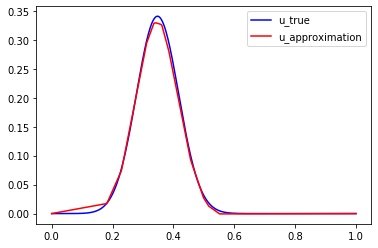

In [33]:
plt.plot(points, yt, color = 'b', label = 'u_true')
plt.plot(points, ymu, color = 'r', label = 'u_approximation')
plt.legend()
# plt.savefig('./24_14/mu.eps')

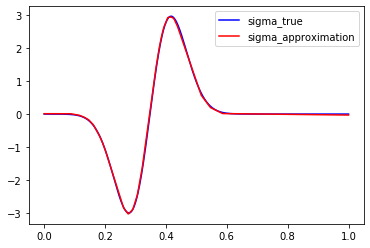

In [34]:
plt.plot(points, y_diff, color = 'b', label = 'sigma_true')
plt.plot(points, ysig, color = 'r', label = 'sigma_approximation')
plt.legend()
# plt.savefig('./24_14/sigma.eps')

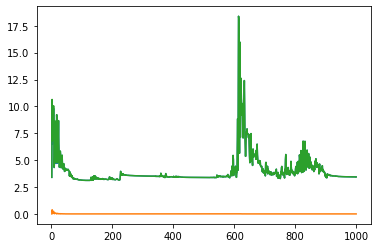

In [35]:
num = np.arange(1, len(loss_bulk_record)+1, 1)
plt.plot(num, loss_bulk_record)
plt.plot(num, loss_surf_record)
plt.plot(num, np.add(loss_bulk_record , loss_surf_record))

In [ ]:
# torch.save(model.state_dict(),'./poisson_equation_24_14')